# Analysis of excitonic states for N2 with pbc

In [1]:
%autosave 0
from BigDFT import Logfiles as lf
from BigDFT import Calculators as C
from futile import Yaml
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
import sys
sys.path.insert(0,'../../')
import Routine as R
outputpath = 'linear-response/'

Autosave disabled


Set up of the main parameters

In [2]:
rVal = [7.0]
virtMax = [296]

## Construction of the excitation dictionary

Read the dipoles and coupling matrix (for a single value of rVal specified by rmultInd)

In [3]:
rmultInd = 0
print 'Read data for rmult = ', rVal[rmultInd]
print 'Maximum value of virtual orbitals = ', virtMax[rmultInd]
print ''

%cd $outputpath
dpath = 'log/TDDFT-Results/transition_dipoles_rmult'+str(rVal[rmultInd])+'_numVirt'+str(virtMax[rmultInd])+'.txt'
dipoles = np.loadtxt(dpath)
cpath = 'log/TDDFT-Results/coupling_matrix_rmult'+str(rVal[rmultInd])+'_numVirt'+str(virtMax[rmultInd])+'.txt'
Cmat = np.loadtxt(cpath)
logpath = 'log/log-Rmult_'+str(rVal[rmultInd])+'_numVirt_'+str(virtMax[rmultInd])+'.yaml'
log = !ls $logpath
Data = lf.Logfile(log[0])
%cd ..

Cmat.shape

Read data for rmult =  7.0
Maximum value of virtual orbitals =  296

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/periodic-bc/linear-response
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/periodic-bc


(2960, 2960)

We set the number of occupied orbitals and define the list nalpha used to analyze the convergence of the excitations with respect to the number of virtual orbitals

In [4]:
numOrb = 5
nalpha = [64,128,192,256,virtMax[rmultInd]]
nalpha

[64, 128, 192, 256, 296]

In [5]:
reload(R)
R.engMax(Data,numOrb,64)

7.7144062661554527

We solve the eigenproblems

In [6]:
reload(R)
eigenproblems = R.solveEigenProblems(numOrb,virtMax[rmultInd],Cmat,dipoles,nalpha)

(640, 640)
(1280, 1280)
(1920, 1920)
(2560, 2560)
(2960, 2960)


We build the dictionary with the first excitations (for each na) and remove the degeneracies

In [7]:
reload(R)
exc = [i for i in range(1,100)]
excitations = R.buildExcitations(numOrb,nalpha,exc,eigenproblems)
excitations = R.removeDegenarices(excitations)

The list allTr contains the labels of the transitions considered (the procedure consider only the transitions that appears for all the values of nalpha). The list is sorted with increasing energy (for each transition it consider the energy of the highest na).

In [9]:
reload(R)
allTr = R.allTransitions(excitations)
print 'Number of transition', len(allTr)
print allTr

Number of distinct transisitons =  88
Number of transisitons removed =  32
Number of transition 56
['3,4to1,2-0', '5to1-0+5to2-0', '3,4to1,2-1', '3,4to1,2-2', '3,4to1,2-3+3,4to1,2-4', '3,4to1,2-5', '3,4to1,2-6', '5to3-0', '5to3-1', '2to1-0+2to2-0', '5to5-0', '5to5-1', '4,5to3,7-0+3,5to3,6-0', '4,5to3,7-1+3,5to3,6-1', '3,5to3,6-3+3,5to3,6-2', '4,5to3,7-3+4,5to3,7-2', '5to8-0', '5to8-1', '5to9-0', '5to9-1', '3to4-0+4to4-0', '3to4-1+4to4-1', '4to5-0+3to5-0', '5to10-0', '4to5-1+3to5-1', '5to10-1', '5to11-0+5to12-0', '5to11-1+5to12-1', '3,4to6,7-0', '3,4,5to6,7,17-0', '3,4to6,7-1', '3,4to6,7-2', '3,4to6,7-3', '5to14-0+5to13-0', '5to14-1+5to13-1', '3,4to6,7-4+3,4to6,7-5', '5to16-0', '5to15-0', '5to15-1', '5to17-0', '5to17-1', '3to8-0+4to8-0', '5to19-0+5to20-0', '5to19-1+5to20-1', '2to3-0', '5to21-0', '5to21-1', '3,4to11,12-0', '4to10-0+3to10-0', '3,4to11,12-1', '3,4to11,12-2', '3,4to11,12-3', '3,4to11,12-4', '4to10-1+3to10-1', '3,4to11,12-5+3,4to11,12-6', '3,4to13,14-0']


We remove the transitions that are not in allTr from excitations

In [11]:
for na in nalpha:
    transitions = excitations[na].keys()
    for tr in transitions:
        if tr not in allTr:
            del excitations[na][tr]
    print 'na = ', na,' - number of transitions', len(transitions)

na =  64  - number of transitions 56
na =  128  - number of transitions 56
na =  192  - number of transitions 56
na =  256  - number of transitions 56
na =  296  - number of transitions 56


We add the key oscillator strenght

In [12]:
fAvg = R.evalOscStrenghtAvg(eigenproblems)
for na,e in excitations.iteritems():
    for tr in e:
        level = excitations[na][tr]['level']
        os = 0.0
        for l in range(len(level)):
            os+=fAvg[na][l]
        e[tr]['oscillatorStrenght'] = os

In [13]:
#excitations[64]

Save the excitation dictionary on a file for further compared analysis in other notebook

In [14]:
excList = {}
for na,e in excitations.iteritems():
    val = {}
    for tr,v in e.iteritems():
        val[tr] = {'weightP' : v['weightP'].tolist(),'weightAlpha' : v['weightAlpha'].tolist(),'level' : v['level'], 'energy' : v['energy'].tolist(), 'oscillatorStrenght' : v['oscillatorStrenght'].tolist()}
    excList[na] = val

In [15]:
print 'Save data for rmult = ', rVal[rmultInd]
print 'Maximum value of virtual orbitals = ', virtMax[rmultInd]
print ''

filename = outputpath+'log/excitations_rmult_'+str(rVal[rmultInd])+'.yaml '
#filename = outputpath+'log/excitations_singlena_rmult'+str(rmult)+'.yaml ' # for the single na analysis
print filename
#Yaml.dump(excList,filename)

Save data for rmult =  7.0
Maximum value of virtual orbitals =  296

linear-response/log/excitations_rmult_7.0.yaml 


### Analysis of the energy (stability and convergence)

We define a routine to plot the energy of the excitations (specified in the list using the level of the excitations) in function of the number of virtual orbitals. 

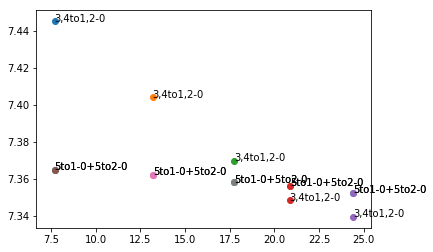

In [16]:
%matplotlib inline
reload(R)
selTr = [1,2,3]
R.pltTrLevel(selTr,excitations,Data,numOrb,True)

Transitions energies can be also plotted specifying the values of the transition labels

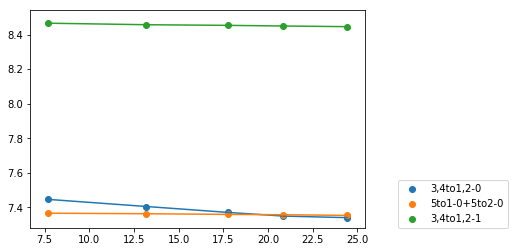

In [17]:
reload(R)
selLab = ['3,4to1,2-0','5to1-0+5to2-0','3,4to1,2-1']#,'3,4to1,2-3+3,4to1,2-4']
R.pltTrLabel(selLab,excitations,Data,numOrb,True)

### Analysis of the someOverBound parameter

For each transition in allTr we build a dictionary that contains a list with the value of 1 - sum of the coefficients of weightAlpha over the bounded virtual orbtilas (a value for each choice of na).

A value close to zero of this parameters denotes a negligible contribution of the unbounded virtual orbitals to the transition. It will be interesting to check if there is a correlation with this parameter and the depenedence of the energy of the transition to the boundary condition adopted (dimension of the box, free boundary condition vs periodic bc) 

In [19]:
# we set the same number of bounded virtual orbitals obtained for free-bc
numVirtBound = 2

print 'number of virtual orbitals with negative energy = ', numVirtBound

number of virtual orbitals with negative energy =  2


In [20]:
reload(R)
sob = R.evalSob(numBound,excitations)
#sob

[64, 128, 192, 256, 296]
Number of distinct transisitons =  56
Number of transisitons removed =  0


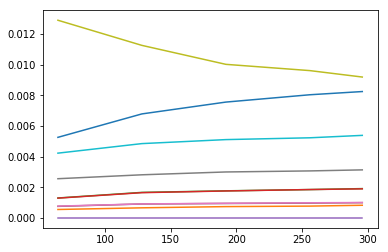

In [21]:
selLab = allTr[0:10] # ['3,4to1,2-0','5to1-0+5to2-0','3,4to1,2-1']
for tr in selLab:
    plt.plot(nalpha,sob[tr])

We further inspect sob and define a procedure that assign to each transition the value of sob (computed for na = nVirtMax) and the derivative of the sob curve (computed as the difference between the sob in the last two points, divided by the difference between the corrispective number of virtual orbitals)

In [22]:
sobStability = R.evalSobStability(sob,nalpha)
#sobStability

The analysis of the derivative of the sob indicates the convergence of the exctiations with respect to the number of virtual orbitals. 

In [29]:
derThreshold = 1.0e-4
highDerivativeTr = []
for tr, s in sobStability.iteritems():
    if abs(s['derivative']) > derThreshold:
        highDerivativeTr.append(tr)
highDerivativeTr

['3to8-0+4to8-0']

In [30]:
sobStability['3to8-0+4to8-0']

{'derivative': 0.0021288320301565827, 'value': 0.99995890855597647}

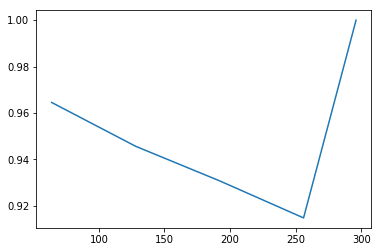

In [31]:
for tr in highDerivativeTr:
    plt.plot(nalpha,sob[tr])

This analysis implies that only the transition '3to8-0+4to8-0' is not stable in terms of the number of virtual orbitals. The same conclusion can be obtained by looking at the (normalized) plot of the sob 

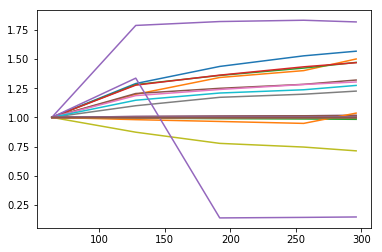

In [25]:
for tr in allTr:
    val = np.array(sob[tr])/sob[tr][0]
    plt.plot(nalpha,val)

We analyze the transitions looking at the value of the sob. In this way we can differenziate between transitions that are mostly project on the bound state on the others. The first set should be more stable with respect to the boundary conditions chosen for the computation.

In [27]:
valThreshold = 1.0e-2
lowSobTr = []
for tr, s in sobStability.iteritems():
    if s['value'] < valThreshold:
        lowSobTr.append(tr)
lowSobTr

['2to3-0',
 '3,4to1,2-5',
 '3,4to1,2-1',
 '5to1-0+5to2-0',
 '5to3-0',
 '5to3-1',
 '3,4to1,2-2',
 '3,4to1,2-0',
 '3,4to1,2-6',
 '2to1-0+2to2-0',
 '3,4to1,2-3+3,4to1,2-4']